### Another Submission - adding more features to Random Forest. 

All this is taken from https://www.kaggle.com/creepykoala/titanic/study-of-tree-and-forest-algorithms/notebook 
I just write it in line by line by myself as it helps me learn and I can query things as I go. 

In [1]:
# Import libraries

import numpy as np
from numpy.random import random_integers
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import pointbiserialr, spearmanr
%matplotlib inline

print('Libraries Ready!')

Libraries Ready!


In [2]:
# Load training data

df = pd.read_csv('/home/sophie/projects/Titanic/data/train.csv', header=0)

People with stronger titles tend to have more help on board. Hence, we will categorize passengers based on titles.

In [3]:
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

# for each name, i.e. Braund, Mr. Owen Harris, we extract the title using x.split and strip and use it as a key to the 
# Title Dictionary. 
# x.split(',')[1] means split the string where the , is. Take the 2nd item. i.e. Mr. Owen Harris
# split('.')[0] means split by the . and take the first item.
# strip() to remove all the other characters. 
df['Title'] = df['Name'].apply(lambda x: Title_Dictionary[x.split(',')[1].split('.')[0].strip()])

print(df['Title'][0:5])
print(df['Name'][0:5])

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object
0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object


In [4]:
name = ['Braund, Mr. Owen Harris', 'Futrelle, Mrs. Jacques Heath (Lily May Peel)']
[name[1].split(',')[1].split('.')[0].strip()]
[name[1].split()]

[['Futrelle,', 'Mrs.', 'Jacques', 'Heath', '(Lily', 'May', 'Peel)']]

Include the ticket prefix as a new column

In [202]:
print (df['Ticket'][0:2])

0    A/5 21171
1     PC 17599
Name: Ticket, dtype: object


In [203]:
# Extract the letters from the beginning of each element of 'Ticket'
def Ticket_Prefix(s):
    s=s.split()[0] # if you don't include anything in split()
    if s.isdigit():
        return 'NoClue'
    else:
        return s
    
df['TicketPrefix'] = df['Ticket'].apply(lambda x: Ticket_Prefix(x))

print(df['TicketPrefix'][0:5])

0         A/5
1          PC
2    STON/O2.
3      NoClue
4      NoClue
Name: TicketPrefix, dtype: object


Fill in missing age with median age, based on Title, Pclass and Sex.

- Make a mask with non-null values for Age. Make a new dataframe out of this new mask.
- Make a groupby object from these values and calculate the median for each group

In [204]:
# Make an array where null values are False.
mask_Age = df.Age.notnull()

# New dataframe where all rows have a value for age. 
Age_Sex_Title_Pclass = df.loc[mask_Age, ["Age", "Title", "Sex", "Pclass"]]

# Groupby object to group by Title, Pclass and Sex
Filler_Ages_1 = Age_Sex_Title_Pclass.groupby(by = ["Title", "Pclass", "Sex"]).median()

# This moves both Sex and Pclass into column headers and does so in that order. 
Filler_Ages = Filler_Ages_1.Age.unstack(level = -1).unstack(level = -1)


In [205]:
print(Age_Sex_Title_Pclass[0:5])
print(len(df[mask_Age]))

    Age Title     Sex  Pclass
0  22.0    Mr    male       3
1  38.0   Mrs  female       1
2  26.0  Miss  female       3
3  35.0   Mrs  female       1
4  35.0    Mr    male       3
714


In [206]:
mask_Age = df.Age.isnull()  # A mask where null values are True

# New DataFrame with missing values for age
Age_Sex_Title_Pclass_missing = df.loc[mask_Age, ["Title", "Sex", "Pclass"]]

print(Age_Sex_Title_Pclass_missing[0:5])

   Title     Sex  Pclass
5     Mr    male       3
17    Mr    male       2
19   Mrs  female       3
26    Mr    male       3
28  Miss  female       3


In [207]:
print(Age_Sex_Title_Pclass[0:5])
print("Before unstacking---------")
print (Filler_Ages_1)
print("After unstacking---------")
print (Filler_Ages)

    Age Title     Sex  Pclass
0  22.0    Mr    male       3
1  38.0   Mrs  female       1
2  26.0  Miss  female       3
3  35.0   Mrs  female       1
4  35.0    Mr    male       3
Before unstacking---------
                        Age
Title   Pclass Sex         
Master  1      male     4.0
        2      male     1.0
        3      male     4.0
Miss    1      female  30.0
        2      female  24.0
        3      female  18.0
Mr      1      male    40.0
        2      male    31.0
        3      male    26.0
Mrs     1      female  40.0
        2      female  31.5
        3      female  31.0
Officer 1      female  49.0
               male    51.0
        2      male    46.5
Royalty 1      female  40.5
               male    40.0
After unstacking---------
Sex     female              male            
Pclass       1     2     3     1     2     3
Title                                       
Master     NaN   NaN   NaN   4.0   1.0   4.0
Miss      30.0  24.0  18.0   NaN   NaN   NaN
Mr        

- Make a function, Age_filler, which is applied to each of the missing dataframe.

In [208]:
# Look-up function for the calculated median ages. 
def Age_filler(row):
    if row.Sex == "female":
        age = Filler_Ages.female.loc[row["Title"], row["Pclass"]]
        return age
    elif row.Sex == "male":
        age = Filler_Ages.male.loc[row["Title"], row["Pclass"]]
        return age
    
# Make a new column on "missing" dataframe and add the median value to each row. 
Age_Sex_Title_Pclass_missing["Age"] = Age_Sex_Title_Pclass_missing.apply(Age_filler, axis= 1)

# reform the 'Age' column.
df["Age"] = pd.concat([Age_Sex_Title_Pclass["Age"], Age_Sex_Title_Pclass_missing["Age"]])

There is one missing Fare value to fill in:

In [209]:
# Filling in with the mean of all fares.
df['Fare'] = df['Fare'].fillna(value=df.Fare.mean())

Drop Cabin and Ticket.   
Combine SibSp and Parch to create FamilySize

In [210]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df = df.drop(['Ticket', 'Cabin'], axis=1)

Now we will use dummy variables to transform the categorical data. 

In [211]:
# get_dummies splits up a column into two seperate columns of 1 and 0, where they are true or false. 
dummies_Sex = pd.get_dummies(df['Sex'], prefix='Sex')

print(df['Sex'][0:3])
print(dummies_Sex[0:3])

0      male
1    female
2    female
Name: Sex, dtype: object
   Sex_female  Sex_male
0         0.0       1.0
1         1.0       0.0
2         1.0       0.0


In [212]:
# Making dummies for the other categorical features
dummies_Embarked = pd.get_dummies(df['Embarked'], prefix= 'Embarked') 
dummies_Pclass = pd.get_dummies(df['Pclass'], prefix= 'Pclass')
dummies_Title = pd.get_dummies(df['Title'], prefix= 'Title')
dummies_TicketPrefix = pd.get_dummies(df['TicketPrefix'], prefix='TicketPrefix')

In [213]:
# Make new dataframes which have the dummies added on to the end.
df = pd.concat([df, dummies_Sex, dummies_Embarked, dummies_Pclass, dummies_Title, dummies_TicketPrefix], axis=1)

# Drop the categorical data
df = df.drop(['Sex','Embarked','Pclass','Title','Name','TicketPrefix'], axis=1)

Finally, set PassengerId as the index:

In [214]:
df = df.set_index(['PassengerId'])

df.head()

,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,TicketPrefix_SOTON/O.Q.,TicketPrefix_SOTON/O2,TicketPrefix_SOTON/OQ,TicketPrefix_STON/O,TicketPrefix_STON/O2.,TicketPrefix_SW/PP,TicketPrefix_W./C.,TicketPrefix_W.E.P.,TicketPrefix_W/C,TicketPrefix_WE/P
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,38.0,1,0,71.2833,1,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,26.0,0,0,7.9250,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,35.0,1,0,53.1000,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,35.0,0,0,8.0500,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Feature Selection

To select features we will correlate each feature against Survived. We need to use different algorithms for the different data types:

- Spearman-Rank correlation for nominal vs nominal data
- Point-Biserial correlation for nominal vs continuous data

In [215]:
# Put the column names into a list called columns
columns = df.columns.values

# initiate lists to store results
param = []
correlation = []
abs_corr=[]

In [216]:
print(len(columns))
#[print(type(df[c])) for c in columns][0:10]
[print("%s"%c) for c in columns[0:10]]

64
Survived
Age
SibSp
Parch
Fare
FamilySize
Sex_female
Sex_male
Embarked_C
Embarked_Q


[None, None, None, None, None, None, None, None, None, None]

In [217]:
for c in columns:
    # Check if binary or continuous
    if len(df[c].unique())<=2:
        corr = spearmanr(df['Survived'], df[c])[0]   # apply spearmanr if
    else:
        corr = pointbiserialr(df['Survived'], df[c])[0]
    
    param.append(c) # name of feature
    correlation.append(corr) # associated correlation
    abs_corr.append(abs(corr))# get rid of -ve values

In [218]:
print(correlation[0:5])
print(abs_corr[0:5])

[1.0, -0.062899950141403885, -0.035322498885735583, 0.081629407083483485, 0.25730652238496243]
[1.0, 0.062899950141403885, 0.035322498885735583, 0.081629407083483485, 0.25730652238496243]


In [219]:
# Create dataFrame for visualisation
param_df = pd.DataFrame({'correlation':correlation, 'parameter':param, 'abs_corr':abs_corr})

# Sort by absolute correlation
param_df = param_df.sort_values(by=['abs_corr'], ascending=False)

# Set parameter name as index
param_df = param_df.set_index('parameter')

print(len(param_df))
param_df[0:10]

64


,abs_corr,correlation
parameter,,
Survived,1.000000,1.000000
Title_Mr,0.549199,-0.549199
Sex_male,0.543351,-0.543351
Sex_female,0.543351,0.543351
Title_Mrs,0.344935,0.344935
Title_Miss,0.332795,0.332795
Pclass_3,0.322308,-0.322308
Pclass_1,0.285904,0.285904
Fare,0.257307,0.257307


In [220]:
print(df.isnull().sum())

Survived                   0
Age                        0
SibSp                      0
Parch                      0
Fare                       0
FamilySize                 0
Sex_female                 0
Sex_male                   0
Embarked_C                 0
Embarked_Q                 0
Embarked_S                 0
Pclass_1                   0
Pclass_2                   0
Pclass_3                   0
Title_Master               0
Title_Miss                 0
Title_Mr                   0
Title_Mrs                  0
Title_Officer              0
Title_Royalty              0
TicketPrefix_A./5.         0
TicketPrefix_A.5.          0
TicketPrefix_A/4           0
TicketPrefix_A/4.          0
TicketPrefix_A/5           0
TicketPrefix_A/5.          0
TicketPrefix_A/S           0
TicketPrefix_A4.           0
TicketPrefix_C             0
TicketPrefix_C.A.          0
                          ..
TicketPrefix_F.C.C.        0
TicketPrefix_Fa            0
TicketPrefix_LINE          0
TicketPrefix_N

Now that we have our correlation, we can use the Decision Tree classifier to see the score against feature space

In [222]:
scoresCV = []
scores = []

# Loop over each of the 64 different parameters
for i in range(1, len(param_df)):
    
    # Make a new dataframe for each feature(selected by df[])
    new_df = df[param_df.index[0:i+1].values]
    
    # .ix supports mixed labels and integer. It can do what .loc and .iloc. both do.
    # X is abs_corr
    X = new_df.ix[:,1::]
    #print(X)
    
    # y is corr
    y = new_df.ix[:,0]
    
    # initialise a DecisionTreeClassifier object
    clf = DecisionTreeClassifier()
    
    # cross_val_score, returns: Array of scores of the estimator for each run of the cross validation.
    # (estimators, data-to-fit, target-variable-to-predict, cv(determines the cross-validation splitting strategy))
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv = 10)
    
    # save the mean of all the runs
    scores.append(np.mean(scoreCV))


In [228]:
new_df = df[param_df.index[0:1].values]
print(list(new_df))
new_df = df[param_df.index[0:3].values]
print(list(new_df))
print(len(scores))

['Survived']
['Survived', 'Title_Mr', 'Sex_male']
63


Plot the scores for different numbers of features

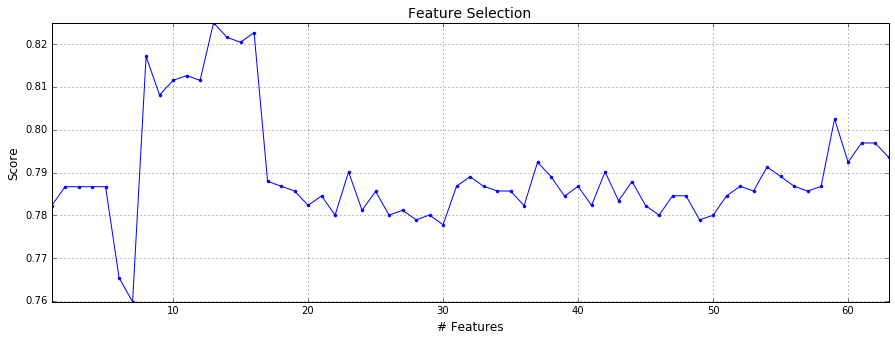

In [223]:
plt.figure(figsize=(15,5))
plt.plot(range(1,len(scores)+1), scores, '.-')
plt.axis("tight")
plt.title('Feature Selection', fontsize=14)
plt.xlabel('# Features', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid();

Does the cross validation score not depend on WHICH features are selected? We put the parameters in order of most highly correlated to lowest. 

Based on the plot, a feature space of 10 dimensions (the top 10 most highly correlating features) provides the most reliable result while avoiding overfit.

In [229]:
best_features=param_df.index[1:10+1].values
print('Best features:\t',best_features)

Best features:	 ['Title_Mr' 'Sex_male' 'Sex_female' 'Title_Mrs' 'Title_Miss' 'Pclass_3'
 'Pclass_1' 'Fare' 'Embarked_C' 'Embarked_S']


Looking at them in histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd65c09f588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd6555f9320>]], dtype=object)

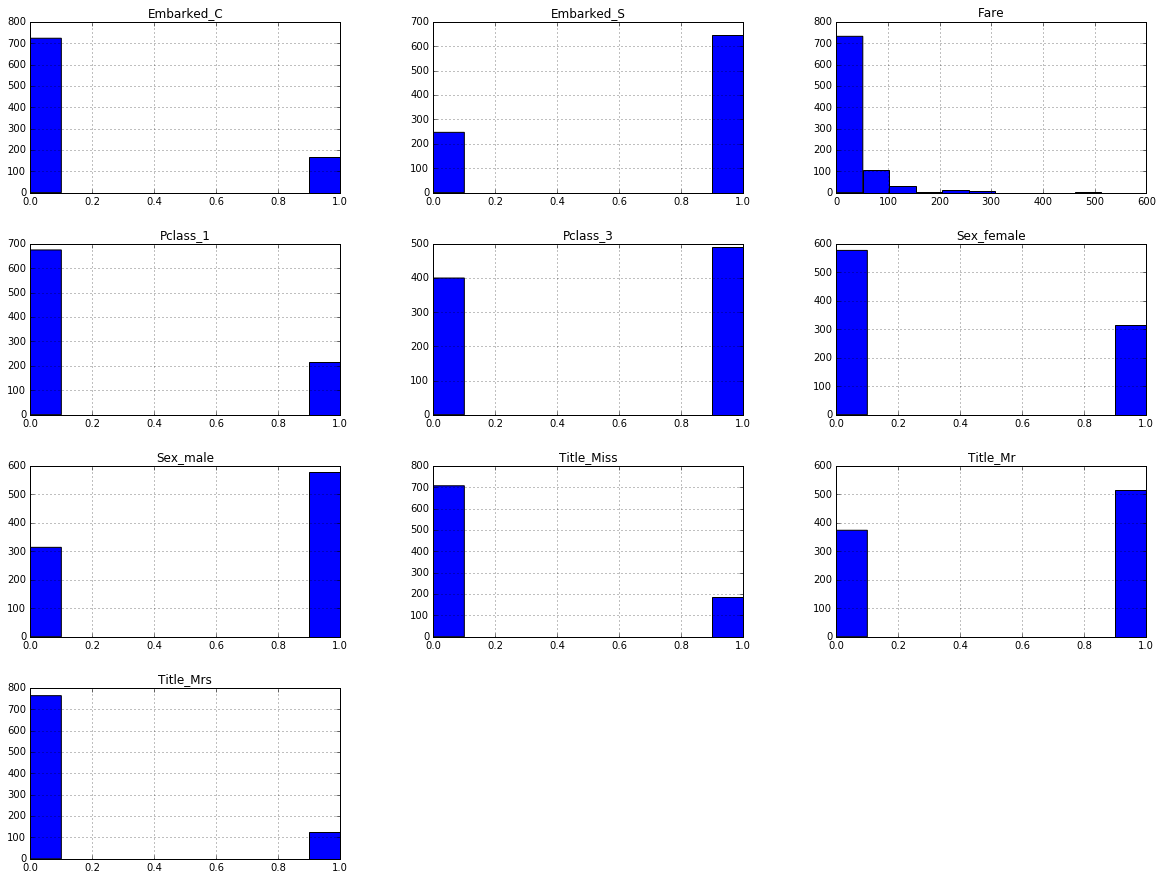

In [230]:
df[best_features].hist(figsize=(20,15))